In [5]:
import pandas as pd
import smogn
import seaborn
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle


In [3]:
df = pd.read_csv(r"C:\Users\fabian\Downloads\parklane_combined_edited.csv")
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
# both chillers running
fil_df['ch_run'] = (fil_df['ch_1_kwe']>=2) & (fil_df['ch_2_kwe']>=2)
fil_df['ch_run'] = fil_df['ch_run'].astype(int)

# filtering additional columns
fil_df = fil_df[(fil_df['ct_tot_kw']>=2) & (fil_df['ct_tot_kw']<=30)]
fil_df = fil_df[(fil_df['lift']>=18) & (fil_df['lift']<=30)]

print("total number of rows after filter is {}".format(len(fil_df)))

# selecting related features only
ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw', 'ch_run']].reset_index()


total number of rows after filter is 211004


In [4]:
ch_sysef_df.head(5)

,index,ch_sysef,lift,sys_cl,ct_tot_kw,ch_run
0,646,0.497447,19.139454,352.233795,7.056000,0
1,648,0.550988,18.783153,349.504547,7.088001,0
2,649,0.570091,19.933795,360.257111,7.104001,0
3,650,0.570109,20.829254,370.950195,7.072001,0
4,651,0.572669,21.348466,374.542725,7.056001,0


In [5]:
rg_mtrx = [

    [0.45, 1, 0],
    [0.50, 0, 0],
    [0.55, 0, 0],
    [0.60, 0, 0],
    [0.65, 1, 0]
]
df_smogn = smogn.smoter(
    data=ch_sysef_df,
    y='ch_sysef',
    drop_na_row=True,
    

)

dist_matrix:  95%|#########5| 19335/20313 [13:05:46<42:19,  2.60s/it]  

<Axes: xlabel='ch_sysef', ylabel='Density'>

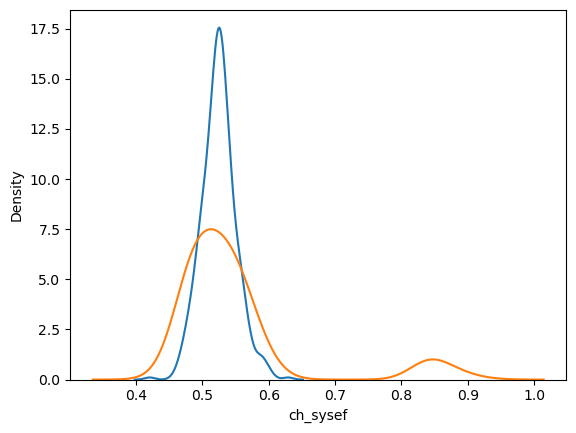

In [ ]:
seaborn.kdeplot(ch_sysef_df['ch_sysef'], label = "Original")
seaborn.kdeplot(df_smogn['ch_sysef'], label = "Modified")

In [6]:
import pandas as pd
df_smogn = pd.read_csv("/Users/admin/Desktop/optimization/parklane/parklane_smogn.csv")

## RF

In [8]:
X = df_smogn[['lift', 'sys_cl', 'ct_tot_kw', 'ch_run']]
y = df_smogn[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

# Training
no_of_trees = [100, 500]
min_samples_splits = [100, 500]

parameter_grid = {
    'max_depth': no_of_trees,
    'min_samples_split': min_samples_splits
}

grid_search = GridSearchCV(
    estimator= RandomForestRegressor(),
    param_grid=parameter_grid,
    cv=5
)

regr = RandomForestRegressor()
grid_search.fit(X_train, y_train)

## save model
filename = 'RF_both_ch_smogn.sav'
pickle.dump(grid_search, open(filename, 'wb'))

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_valida

## XGBoost

In [9]:
from xgboost import XGBRegressor

max_depth = [5, 20, 50]
gamma = [1, 5, 10]
alpha = [20, 50, 100]
reg_lambda = [0.2, 0.5, 1]
n_estimators = [50, 100, 150]


parameter_grid = {
    'max_depth': max_depth,
    'gamma': gamma,
    'reg_alpha': alpha,
    'reg_lambda': reg_lambda
}

bst_grid_search = GridSearchCV(
    estimator= XGBRegressor(),
    param_grid=parameter_grid,
    cv=5
)

bst_grid_search.fit(X_train, y_train)

## save model
filename = 'XGB_both_ch_smogn.sav'
pickle.dump(bst_grid_search, open(filename, 'wb'))

In [14]:
bst_grid_search.predict([[22.5, 375, 16, 1]])

array([0.5600155], dtype=float32)